In [30]:
import os
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image

## I. Data Handling

In [31]:
transform = transforms.Compose([
    # ensure images are of uniform size
    # this is necessary for the neural network to be able to process the images
    transforms.Resize((224, 224)),

    # ensure the end result is a tensor
    # this converts the image from [0,255] to [0,1]
    # making it compatible with the neural network
    transforms.ToTensor(),

    # normalise the data
    transforms.Normalize(
        # this is the mean and standard deviation of the ImageNet dataset
        # the pixel value, for each channel, is subtracted by the mean and divided by the standard deviation
        # this should shift the pixel values to be centred around zero (mean: 0, std: 1)
        # this allows faster and more stable convergence during optimisation
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# LOAD DATASET
rootDir = globals()['_dh'][0] # os.path.dirname(os.path.abspath(__file__))
dataDir = os.path.join(rootDir, '..', 'data')
artDir = os.path.join(dataDir, 'art')

dataSet = ImageFolder(root=artDir, transform=transform) # load each subdirectory as a class

with open(os.path.join(dataDir, 'manifest.json'), 'r') as f:
    trueClasses = json.load(f)

print(dataSet)
print(dataSet.classes)
print(trueClasses)

Dataset ImageFolder
    Number of datapoints: 16
    Root location: d:\Programming\UoM\virtual-turntable\server\modelling\sandbox\..\data\art
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
['AbbeyRoad_TheBeatles_1969', 'InRainbows_Radiohead_2007', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978", 'KidA_Radiohead_2000', 'OKComputer_Radiohead_1997', 'Revolver_TheBeatles_1966', "Sgt.Pepper'sLonelyHeartsClubBand_TheBeatles_1967", 'TheDarkSideOfTheMoon_PinkFloyd_1973', 'TheRiseAndFallOfZiggyStardustAndTheSpidersFromMars_DavidBowie_1972', 'TheVelvetUnderground&Nico_TheVelvetUnderground&Nico_1967', 'WishYouWereHere_PinkFloyd_1975', '_null']
{"JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978": {'name': "Jeff Wayne's Musical Version of The War of the Worlds", 'artist

Note: Data augmentation should be done in the future, to create a more robust dataset.

In [32]:
# SPLIT DATA
trainLoader = DataLoader(dataSet, batch_size=8, shuffle=True)
validationLoader = DataLoader(dataSet, batch_size=8, shuffle=True)

## II. Model

In [33]:
class SimpleCNN(nn.Module):
    """
    This is a simple convolutional neural network, for POC.
    It has two convolutional layers and two fully connected layers (see below).
    It effectively learns the 'ID' of the image (albumName_artistName).
    """

    def __init__(self, numClasses):
        super(SimpleCNN, self).__init__()

        # This is the architecture of the neural network.
        # It is composed of two convolutional layers and two fully connected layers.
        # conv1 -> pool -> conv2 -> pool -> fc1 -> fc2

        # CONVOLUTIONAL LAYER 1
        self.conv1 = nn.Conv2d(
            3, # 3 channels (RBG)
            32, # 32 output filters (feature maps)
            kernel_size=3, # each filter will scan 3x3 patches of the image
            stride=1, # each filter will move 1 pixel at a time
            padding=1 # the input is padded, to esnure the output is the same size as the input
        )

        # MAX-POOLING LAYER
        # reduces spatial dimensions of the input feature maps
        # this reduces the number of parameters and computations in the network
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # CONVOLUTIONAL LAYER 2
        # the 32 feature maps are now fed into a second layer, resulting in 64 output filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # FULLY CONNECTED LAYER 1
        self.fc1 = nn.Linear(
            64 * 56 * 56, # 64 feature maps, each 56x56 pixels
            128 # 128 output neurons
        )

        # FULLY CONNECTED LAYER 2
        # this layer outputs logits (raw scores) for each class
        self.fc2 = nn.Linear(128, numClasses)

    def forward(self, x):
        """_summary_

        Args:
            x (_type_): _description_

        Returns:
            _type_: _description_
        """

        # pool the first convolutional layer
        # the size of the feature maps are halved
        x = self.pool(
            # apply the ReLU activation function
            # this introduces non-linearity to the model
            torch.relu(
                # apply the first convolutional layer
                # the 32 filters are applied to the input image
                self.conv1(x)
            )
        )

        # pool the second convolutional layer
        x = self.pool(torch.relu(self.conv2(x)))

        # flatten the feature maps
        x = x.view(-1, 64 * 56 * 56)

        # fully-connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x) # no activation function, as this is handled by the loss function

        return x

numClasses = len(dataSet.classes)
model = SimpleCNN(numClasses=numClasses)

## III. Training

In [34]:
# LOSS FUNCTION
# used to compute the error between the model's predictions and the true labels
criterion = nn.CrossEntropyLoss()

# OPTIMISER
# updates the model's weights, based on gradients
optimiser = optim.Adam(model.parameters(), lr=0.001)

In [35]:
def train(model, trainLoader, criterion, optimiser, epochs=5):
    """_summary_

    Args:
        model (_type_): _description_
        trainLoader (_type_): _description_
        criterion (_type_): _description_
        optimiser (_type_): _description_
        epochs (int, optional): _description_. Defaults to 5.
    """

    # EPOCH LOOP
    # an epoch is a complete pass through the dataset
    # we do this several times, to allow the model to learn
    for epoch in range(epochs):

        model.train() # set the model to training mode (this is necessary for dropout and batch normalisation)

        # initialsie some statistic-trackers
        runningLoss = 0.0 # cumulative loss
        correct, total = 0, 0 # correct predictions, total predictions

        # TRAINING LOOP
        for images, labels in trainLoader:
            optimiser.zero_grad() # prevent accumulated gradients from previous iterations overflowing

            # FORWARD PASS
            # pass the images into the model, producing a prediction
            outputs = model(images)

            # COMPUTE LOSS
            # compare the model's predictions to the true labels
            loss = criterion(outputs, labels)

            # BACKPROPAGATION
            # compute the gradients of the loss, with respect to the model's parameters/weights
            loss.backward()
            # and update the model's weights accordingly
            optimiser.step()

            # track stats
            runningLoss += loss.item()
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'(Epoch {epoch+1}) Loss: {runningLoss/len(trainLoader)}\t Accuracy: {correct/total}')

train(model, trainLoader, criterion, optimiser, epochs=5)

(Epoch 1) Loss: 8.9410400390625	 Accuracy: 0.125
(Epoch 2) Loss: 8.864165306091309	 Accuracy: 0.3125
(Epoch 3) Loss: 2.063830614089966	 Accuracy: 0.4375
(Epoch 4) Loss: 0.419629231095314	 Accuracy: 1.0
(Epoch 5) Loss: 0.14713069424033165	 Accuracy: 1.0


## IV. Validation

In [36]:
def validate(model, testImage):
    model.eval()

    with torch.no_grad():
        outputs = model(testImage)

        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        predictedProb, predictedClass = torch.max(probabilities, 1)

        predictedID = dataSet.classes[predictedClass.item()]
        print(f'Predicted: {predictedID} ({predictedProb.item()})')
        print(trueClasses.get(predictedID, 'Unknown'))

def validateImage(model, imagePath: str):
    testImage = Image.open(imagePath)
    display(testImage.reduce(7))
    testImage = transform(testImage)
    testImage = testImage.unsqueeze(0) # add batch dimension, as model expects it

    validate(model, testImage)

Seen data (hopefully, expacted).

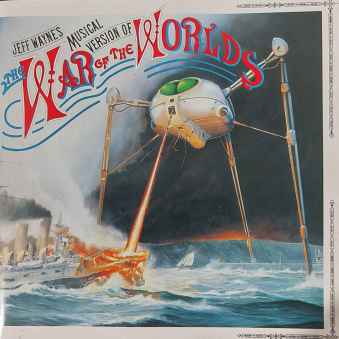

Predicted: JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978 (0.7113175988197327)
{'name': "Jeff Wayne's Musical Version of The War of the Worlds", 'artist': 'Jeff Wayne', 'year': 1978}


In [37]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).jpg"))

### Unseen Data

Unseen data (the model is not expected to perform well).

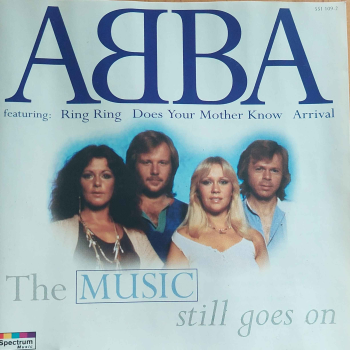

Predicted: Revolver_TheBeatles_1966 (0.44689181447029114)
{'name': 'Revolver', 'artist': 'The Beatles', 'year': 1966}


In [38]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', 'TheMusicStillGoesOn_ABBA.jpg'))

Note: the sum of the probabilities will be 1. Therefore, with a small datatset, the model may be confidently wrong (i.e. a high probability for the wrong class), as this is moreso a measure of 'how confident I am it is this, compared to the other options', as opposed to 'how confident I am that it is this, and not anything else'. This is important to note when interpreting the results (we should have a high standard for confidence). However, as the dataset grows, the liklihood of any one class being highly-favoured, when the true result lies outside of the trained classes, should decrease.

#### Bad Data

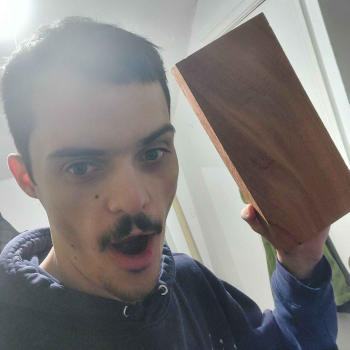

Predicted: Sgt.Pepper'sLonelyHeartsClubBand_TheBeatles_1967 (0.3023284375667572)
{'name': "Sgt. Pepper's Lonely Hearts Club Band", 'artist': 'The Beatles', 'year': 1967}


In [39]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', 'MahoganyJack.jpg'))

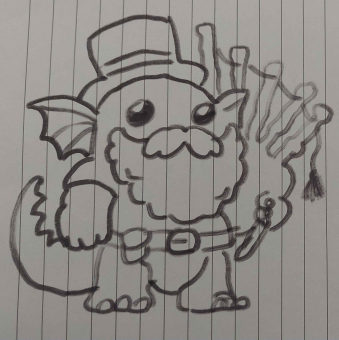

Predicted: Revolver_TheBeatles_1966 (0.2305876463651657)
{'name': 'Revolver', 'artist': 'The Beatles', 'year': 1966}


In [40]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', 'Haranthur.jpg'))

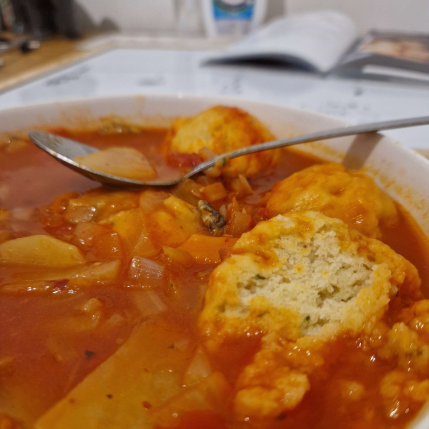

Predicted: InRainbows_Radiohead_2007 (0.840421199798584)
{'name': 'In Rainbows', 'artist': 'Radiohead', 'year': 2007}


In [41]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', 'Dumplings.jpg'))

In these examples, we see that the image is (fairly) confidently wrong, about this data, as it has not concept of what is a coverart, and what is not.

The best way to counter this, is to have a confidence threshold. If the model is not confident, it should not make a prediction, without using other fallback methods (e.g. OCR, etc.). As  the dataset increases, the confidence level should naturally decrease for unseen data, as the model will have more data to compare against.

### 'Empty' Data

However, there is one example of bad data that we can theoretically handle quite well: as the camera will be fixed, we have a strong idea of what background to expect. Therefore, we can have one class be trained on the background, whichmeans that when there is 'no data', it will be classified as the background. This will be useful for the 'unseen data' section, as we can see how well the model can differentiate between the background and the other classes.

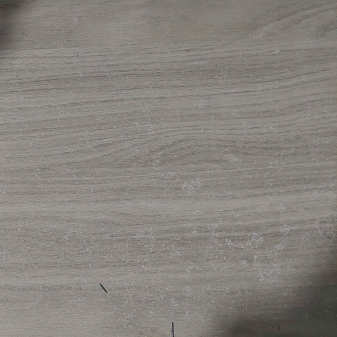

Predicted: _null (0.3076798915863037)
Unknown


In [42]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'art', '_null', 'null.jpg'))

**As the results of this data are essentially just a matter of 'is this already seen'?, formal evaluation of the model has been skipped.**

## V. Observations

### 1. Model performs terribly on data belonging to unseen classes.
This is expected, and can be improved by:
- using a multi-headed model, for deeper analysis;
- using alternative fallback methods, such as barcode scanning, or OCR;
- and can be minimised by using a larger dataset, with more classes.

### 2. This model is not robust.
Rotating, flipping, warping, discolouring, and other augmentations to the base image can result in a completely different prediction. This is expected, and can be improved by:
- using an augmentated dataset, to make these cases not so 'unseen';
- using a larger dataset, with more classes (the arbitrary similarities between classes will be less likely to be learned);

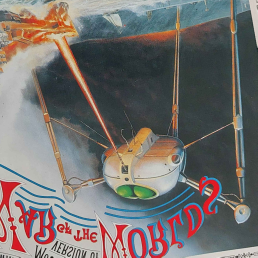

Predicted: Sgt.Pepper'sLonelyHeartsClubBand_TheBeatles_1967 (0.2028360366821289)
{'name': "Sgt. Pepper's Lonely Hearts Club Band", 'artist': 'The Beatles', 'year': 1967}


In [43]:
testImage = Image.open(os.path.join(rootDir, '..', 'data', 'misc', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).jpg"))
testImage = testImage.transpose(Image.FLIP_TOP_BOTTOM)
testImage = testImage.rotate(10)
testImage = testImage.crop((400, 400, 2200, 2200))
display(testImage.reduce(7))
testImage = transform(testImage)
testImage = testImage.unsqueeze(0) # add batch dimension, as model expects it


validate(model, testImage)

## VI. Experiments

### 1. How does artificial augmentation improve results?
### Rotations
### Scales / Crops
### 'Lighting' (colour augmentation)
### Wraping

### 2. How does the chosen image transformation affect results?
#### Does fidelity improve accuracy?